In [1]:
from keras.layers import Embedding, Dense, Dropout, Input#, LSTM, Bidirectional
from keras.layers import MaxPooling1D, Conv1D, Flatten
from keras.preprocessing import sequence#, text
from keras.models import Model
from keras.utils import np_utils
from keras.callbacks import Callback

from gensim.models.keyedvectors import KeyedVectors

from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix as confmat,
    classification_report as creport
)

from utils import *

np.random.seed(42)

Using TensorFlow backend.


## Language Model and Data

In [2]:
algo = 'sg' # or 'cbow'
path = './arabic_bins/web_{}_300'.format(algo)
#path = './arabic_bins/cc.ar.300.vec'

In [3]:
# language model
WORD_MODEL, _, MAX_FEATURES, EMBED_SIZE = get_init_parameters(path)#, ext='vec')

# load data
data_paths = ['./data/arabic_dataset_classifiction.csv']
x_train, x_test, y_train, y_test, MAX_TEXT_LENGTH = split_datasets(data_paths, test_size=0.2, seed=42)
CLASSES_LIST = np.unique(y_train)
print('Label categories: ' + str(CLASSES_LIST))

# 
x_train, x_test, y_train, y_test, train_y_cat, word_index = class_str_2_ind(x_train, x_test, 
                                                                            y_train, y_test,
                                                                            CLASSES_LIST, MAX_FEATURES,
                                                                            MAX_TEXT_LENGTH)
test_cat_y = np_utils.to_categorical(y_test, len(CLASSES_LIST))

Dataset splited.
Label categories: ['0' '1' '2' '3' '4']
Converting data to trainable form...
Number of training examples: 89382
Number of testing examples: 22346


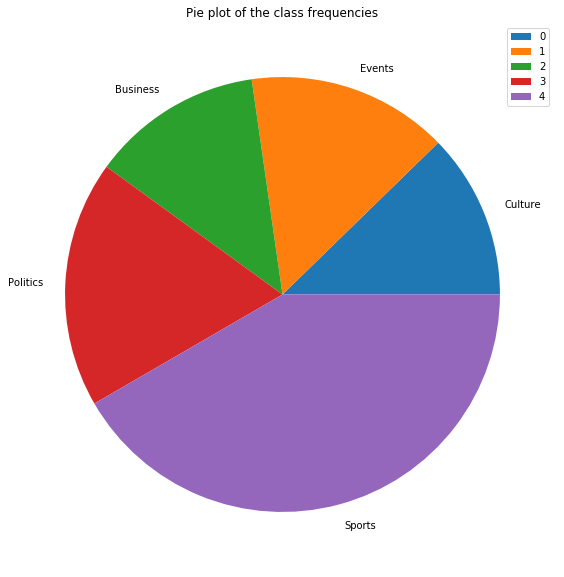

In [4]:
LABELS = (
    'Culture', 'Events', 'Business', 'Politics', 'Sports'
)

tmp = np.concatenate((y_train, y_test))
unique, counts = np.unique(tmp, return_counts=True)
del tmp
plt.figure("Target Pie", figsize=(10, 10))
plt.title("Pie plot of the class frequencies")
plt.pie(counts, labels=LABELS)
plt.legend(unique)
plt.savefig("./img/stats_classes.png")
plt.show();

**Try less timesteps**

In [5]:
# Sequence length
print("Original sequence length : "+str(MAX_TEXT_LENGTH))

# CHANGE MAX LENGTH (timesteps)
MAX_TEXT_LENGTH = 2000

Original sequence length : 5049


In [6]:
def get_model(embedding_weights, word_index, vocab_dim, max_length, print_summary=True):
    """
    DOC
    """
    inp = Input(shape=(max_length,))
    model = Embedding(input_dim=len(word_index)+1,
                      output_dim=vocab_dim,
                      trainable=False,
                      weights=[embedding_weights])(inp)

    model = Conv1D(filters=32, kernel_size=5, padding='same', activation='relu')(model)
    model = MaxPooling1D(pool_size=2)(model)
    model = Flatten()(model)
    model = Dropout(0.1)(model)
    model = Dense(200, activation='relu')(model)
    model = Dropout(0.1)(model)
    model = Dense(5, activation='softmax')(model)
    model = Model(inputs=inp, outputs=model)
    
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    if print_summary:
        model.summary()
    return model


def get_main_model(word_index, WORD_MODEL, EMBED_SIZE, MAX_TEXT_LENGTH):
    """
    DOC
    """
    tmp = get_embedding_matrix(word_index, WORD_MODEL, EMBED_SIZE)
    model = get_model(tmp, word_index, EMBED_SIZE, MAX_TEXT_LENGTH, print_summary=True)
    return model


class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))

def train_fit_predict(model, x_train, x_test, y_train, y_test, batch_size, epochs, TestCallback=TestCallback):
    """
    DOC 
    """
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs, verbose=1,
                        validation_data=(x_test, y_test),
                        callbacks=[TestCallback((x_test, y_test))])
    return history, model

In [7]:
model = get_main_model(word_index, WORD_MODEL, EMBED_SIZE, MAX_TEXT_LENGTH)

Building embedding matrix...
Embedding matrix built.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 2000, 300)         115239600 
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2000, 32)          48032     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1000, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32000)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32000)             0         
_________________________________________________________________
dense_1 (Dense)        

In [8]:
del WORD_MODEL
del word_index

## Start Learning

In [9]:
time_start = time()
history, model = train_fit_predict(model,
                               x_train[:, :MAX_TEXT_LENGTH],
                               x_test[:, :MAX_TEXT_LENGTH],
                               train_y_cat, test_cat_y,
                               batch_size=10, epochs=20)
time_start = time() - time_start

print("Took : "+str(np.round(time_start, 2))+" (s)") 

Train on 89382 samples, validate on 22346 samples
Epoch 1/20
89382/89382 [==============================] - 55s 614us/step - loss: 0.2781 - acc: 0.9106 - val_loss: 0.2658 - val_acc: 0.9151

Testing loss: 0.2658172140032477, acc: 0.9151078492688437

Epoch 2/20
89382/89382 [==============================] - 54s 605us/step - loss: 0.1772 - acc: 0.9444 - val_loss: 0.1811 - val_acc: 0.9429

Testing loss: 0.18105686609004357, acc: 0.9429428085563412

Epoch 3/20
89382/89382 [==============================] - 54s 608us/step - loss: 0.1510 - acc: 0.9526 - val_loss: 0.1742 - val_acc: 0.9454

Testing loss: 0.17422712602172735, acc: 0.9454488499060234

Epoch 4/20
89382/89382 [==============================] - 54s 607us/step - loss: 0.1291 - acc: 0.9593 - val_loss: 0.2320 - val_acc: 0.9273

Testing loss: 0.23195904402041792, acc: 0.927280050120827

Epoch 5/20
89382/89382 [==============================] - 54s 608us/step - loss: 0.1087 - acc: 0.9654 - val_loss: 0.1787 - val_acc: 0.9461

Testing loss

In [10]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'acc', 'loss'])

In [11]:
model.evaluate(x_test[:, :MAX_TEXT_LENGTH], test_cat_y)

22346/22346 [==============================] - 3s 120us/step


[0.3053504228721171, 0.9424505504340822]

In [12]:
y_pred = np.argmax(model.predict(x_test[:, :MAX_TEXT_LENGTH]), axis=1)
# y_pred = np_utils.to_categorical(np.argmax(y_pred, axis=1), len(CLASSES_LIST))

cm = confmat(np.argmax(test_cat_y, axis=1), y_pred)

print("Confusion Matrix :\n\n {}\n".format(cm))
print(creport(np.argmax(test_cat_y, axis=1), y_pred))

Confusion Matrix :

 [[2553   18   43  109   46]
 [  15 3196   25   87   18]
 [  27   30 2497  283   52]
 [  76  112  200 3724   57]
 [  23   20   15   30 9090]]

              precision    recall  f1-score   support

           0       0.95      0.92      0.93      2769
           1       0.95      0.96      0.95      3341
           2       0.90      0.86      0.88      2889
           3       0.88      0.89      0.89      4169
           4       0.98      0.99      0.99      9178

   micro avg       0.94      0.94      0.94     22346
   macro avg       0.93      0.93      0.93     22346
weighted avg       0.94      0.94      0.94     22346



**Early Stopping**

In [13]:
n = np.argmin(history.history['val_loss'])

print("Accuracy on train : {} %".format(np.round(history.history['acc'][n]*100, 2)))
print("Accuracy on test : {} %".format(np.round(history.history['val_acc'][n]*100, 2)))
print("Loss on train : {}".format(np.round(history.history['loss'][n]*100, 2)))
print("Loss on test : {}".format(np.round(history.history['val_loss'][n]*100, 2)))

Accuracy on train : 95.26 %
Accuracy on test : 94.54 %
Loss on train : 15.1
Loss on test : 17.42


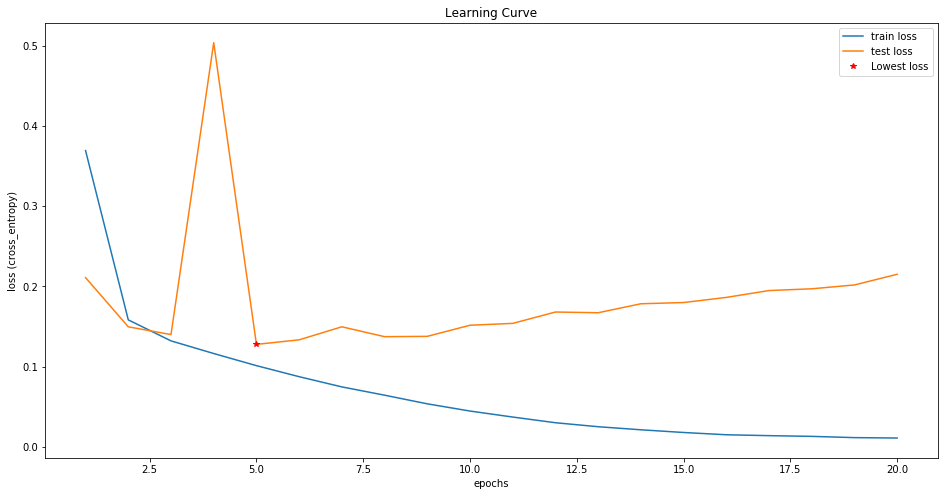

In [15]:
plt.figure("Loss Plot", figsize=(16, 8))
plt.plot(range(1, len(history.history['loss'])+1), history.history['loss'], label="train loss")
plt.plot(range(1, len(history.history['val_loss'])+1), history.history['val_loss'], label="test loss")
plt.plot(n+1,history.history["val_loss"][n],"r*", label="Lowest loss")
plt.legend()
plt.title("Learning Curve")
plt.ylabel("loss (cross_entropy)")
plt.xlabel("epochs")
#plt.savefig("./img/loss_500_2000_sg_true_40.png")
plt.show();

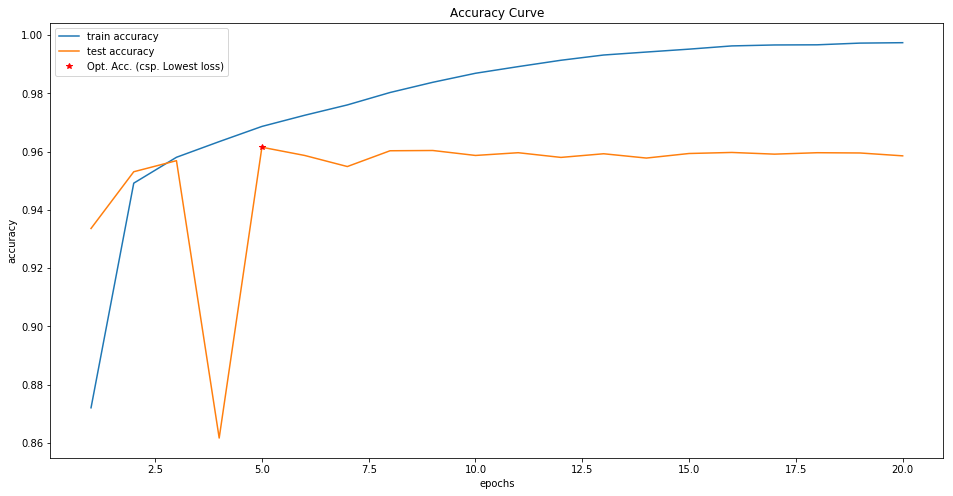

In [16]:
plt.figure("Accuracy Plot", figsize=(16, 8))
plt.plot(range(1, len(history.history['acc'])+1), history.history['acc'], label="train accuracy")
plt.plot(range(1, len(history.history['val_acc'])+1), history.history['val_acc'], label="test accuracy")
plt.plot(n+1,history.history["val_acc"][n],"r*", label="Opt. Acc. (csp. Lowest loss)")
plt.legend()
plt.title("Accuracy Curve")
plt.ylabel("accuracy")
plt.xlabel("epochs")
#plt.savefig("./img/acc_500_2000_sg_true_40.png")
plt.show()

## Save results

In [14]:
import shelve

tmp = shelve.open('fasttext-true')
#tmp['results'] = history.history
tmp.close()

## Recompute results

In [38]:
import shelve

tmp_list = []
tmp = shelve.open('fasttext')
for i in range(1,11):
    histo_tmp = tmp[str(i)]
    n = np.argmin(histo_tmp['val_loss'])
    tmp_list.append(np.round(histo_tmp['acc'][n]*100, 2))
tmp.close()

In [39]:
np.std(tmp_list)

0.009165151389911407